# Volume 3: Kalman Filter
    Daniel Perkins
    MATH 407
    1/23/25

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from scipy.stats import multivariate_normal

## Problem 1

Begin implementing a `KalmanFilter` class by writing an initialization method that stores the transition and observation models, noise covariances, and control vector.

## Problem 4
Add a method to your `KalmanFilter` class to estimate a state sequence corresponding to a given observation sequence and initial state estimate by implementing the `estimate()` method.

## Problem 6

Add a method `predict()` to your class that predicts the next $k$ states given a current state estimate but in the absence of observations.

## Problem 8
Add a method `rewind()` to your class that rewinds the system from a given state estimate, returning predictions for the previous states. 

In [188]:

class KalmanFilter(object):
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.

        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        # Store the attributes
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.u = u


    def estimate(self, x, P, z):
        """
        Compute the state estimates using the Kalman filter.
        If x and P correspond to time step k, then z is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape (m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        # Initialize things
        n, N = np.shape(x)[0], np.shape(z)[1]
        out = np.empty((n, N))
        
        # Step 0
        K = P @ self.H.T @ np.linalg.inv(self.H @ P @ self.H.T + self.R)
        x = x + K @ (z[:,0] - self.H @ x)
        P = (np.eye(np.shape(K)[0]) - K @ self.H) @ P
        out[:, 0] = x
        
        for i in range(1, N):
            # Predict
            x = self.F @ x + self.u
            P = self.F @ P @ self.F.T + self.Q
            
            # Update
            K = P @ self.H.T @ np.linalg.inv(self.H @ P @ self.H.T + self.R)
            x = x + K @ (z[:,i] - self.H @ x)
            P = (np.eye(np.shape(K)[0]) - K @ self.H) @ P
            out[:, i] = x
        
        return out
            
            
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        out = np.empty((x.shape[0], k))
        for i in range(k):
            x = self.F @ x + self.u  # Equation above prob 6
            out[:, i] = x   # Store it
            
        return out
    

    def rewind(self, x, k):
        """
        Predict the k states preceding the current state estimate x.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of preceding states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        out = np.empty((x.shape[0], k))
        for i in range(k):
            x = np.linalg.inv(self.F) @ (x - self.u)  # Equation above prob 8
            out[:, -i - 1] = x   # Store it
        
        return out


## Problem 2 

Work out the transition and observation models $F$ and $H$, along with the control vector $\mathbf{u}$, corresponding to the projectile. 
Assume that the noise covariances are given by 

$Q = 0.1 \cdot I_4 $

$R = 5000 \cdot I_2. $

Instantiate a `KalmanFilter` object with these values.

In [189]:
# Define noise variances
Q = 0.1*np.eye(4)
R = 5000*np.eye(2)

# State transition matrix
F = np.array([[1, 0, 0.1, 0], 
            [0, 1, 0, 0.1],
            [0, 0, 1, 0], 
            [0, 0, 0, 1]])
u = np.array([0, 0, 0, -.98])  # Control vector
H = np.array([[1, 0, 0, 0],
            [0, 1, 0, 0]])

# Instantiate a KalmanFilter object with these values.
filter = KalmanFilter(F, Q, H, R, u)

## Problem 3

Write a function `evolve()` that generates a state and observation sequence by evolving the dynamical system from a given initial state.

Simulate the true and observed trajectories of a projectile with initial state

$x_0 = \left( \begin{array}{c} 0 \\ 0 \\ 300 \\ 600 \end{array} \right).$

Plot both the true trajectory (as a blue line) and the observed trajectory (as red dots).

In [104]:
def evolve(x0, N, F, Q, H, R, u):
    """
    Generate the first N states and observations from the dynamical system.

    Parameters
    ----------
    x0 : ndarray of shape (n,)
        The initial state.
    N : integer
        The number of time steps to evolve.
    F : ndarray of shape (n,n)
        The state transition model.
    Q : ndarray of shape (n,n)
        The covariance matrix for the state noise.
    H : ndarray of shape (m,n)
        The observation model.
    R : ndarray of shape (m,m)
        The covariance matrix for observation noise.
    u : ndarray of shape (n,)
        The control vector.

    Returns
    -------
    states : ndarray of shape (n,N)
        States 0 through N-1, given by each column.
    obs : ndarray of shape (m,N)
        Observations 0 through N-1, given by each column.
    """
    # Initialize things
    states = np.empty((np.shape(x0)[0], N))
    states[:, 0] = x0
    obs = np.empty((np.shape(H)[0], N))
    obs[:, 0] =  H @ x0 + multivariate_normal.rvs(cov=R)
    x = x0
    
    # Step through
    for i in range(1, N):
        w = multivariate_normal.rvs(cov=Q)  # Sample noise
        x = F @ x + u + w   # Equation 23.2
        v = multivariate_normal.rvs(cov=R)
        z = H @ x + v  # Equation 23.3
        
        # Store it
        states[:, i] = x
        obs[:, i] = z
    
    return states, obs

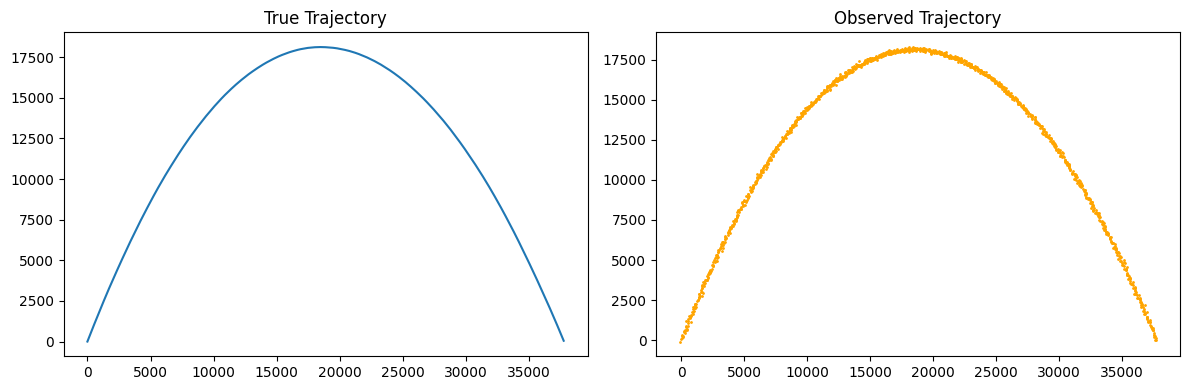

In [190]:
# Get the states
x0 = np.array([0, 0, 300, 600])
states, obs = evolve(x0,1250, F, Q, H, R, u)

# Extract data
xs = states[0, :]
ys = states[1, :]
obs_x = obs[0, :]
obs_y = obs[1, :]

# Stop before negative ys
index = np.argmax(ys < 0)
xs = xs[:index]
ys = ys[:index]
obs_x = obs_x[:index]
obs_y = obs_y[:index]

# Plot it
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("True Trajectory")
plt.plot(xs, ys)

plt.subplot(122)
plt.title("Observed Trajectory")
plt.scatter(obs_x, obs_y, s=1, c="orange")
plt.tight_layout()
plt.show()

## Problem 5

Calculate an initial state estimate $\hat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200. 
For the velocity, compute the average velocity between the observations $\mathbf{z}_k$ and $\mathbf{z}_{k+1}$ for $k = 200,\dots, 208$, then average these 9 values and take this as the initial velocity estimate.

Using the initial state estimate, $P_{200} = 10^6\cdot Q$ and your Kalman filter, compute the next 600 state estimates, i.e. compute $\hat{\mathbf{x}}_{201},\dots,\hat{\mathbf{x}}_{800}$. 
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entire true state sequence (as
a blue curve). 
Zoom in to see how well it follows the true path. 

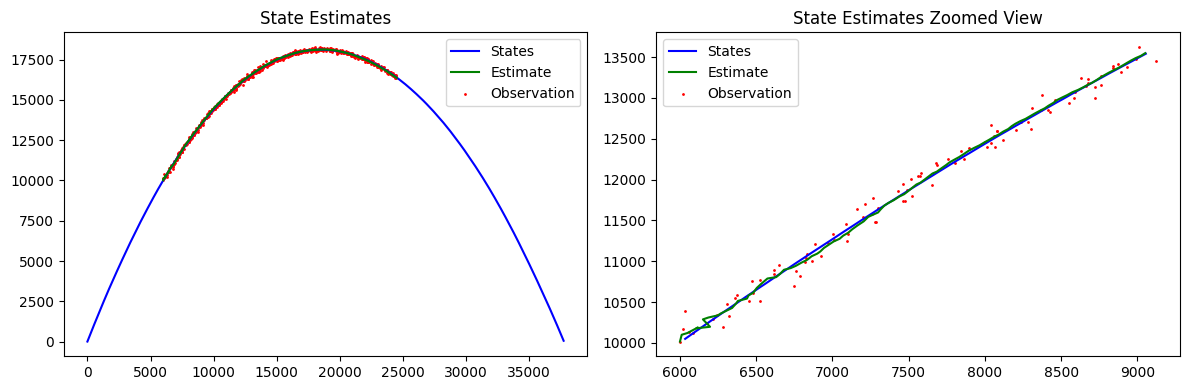

In [191]:
k = 200
s0 = obs[:, k]
# Compute average velocity for k=200,...,208
velocities = np.array([obs[:, k+i+1] - obs[:, k+i] for i in range(9)])
V0 = np.mean(velocities, axis=0)
x0 = np.concatenate([s0, V0])  # Get the initial state

# Intialize z and P
P = (10**6)*Q
z = obs[:, 200:801]

# Compute the estimate and extract the data
out = filter.estimate(x0, P, z)
est_xs = out[0, :]
est_ys = out[1, :]
obs_xs = z[0, :]
obs_ys = z[1, :]

# Plot it
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("State Estimates")
plt.plot(xs, ys, c="blue", label="States")
plt.plot(est_xs, est_ys, c="green", label="Estimate")
plt.scatter(obs_xs, obs_ys, s=1, c="red", label="Observation")
plt.legend()
# Zoom in
plt.subplot(122)
plt.title("State Estimates Zoomed View")
plt.plot(xs[200:300], ys[200:300], c="blue", label="States")
plt.plot(est_xs[:100], est_ys[:100], c="green", label="Estimate")
plt.scatter(obs_xs[:100], obs_ys[:100], s=1, c="red", label="Observation")
plt.legend()
plt.tight_layout()
plt.show()

## Problem 7

Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 5, predict the future states of the projectile until it hits the ground. 
Predicting approximately the next 450 states should be sufficient.

Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.

/tmp/ipykernel_1223/1296460949.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


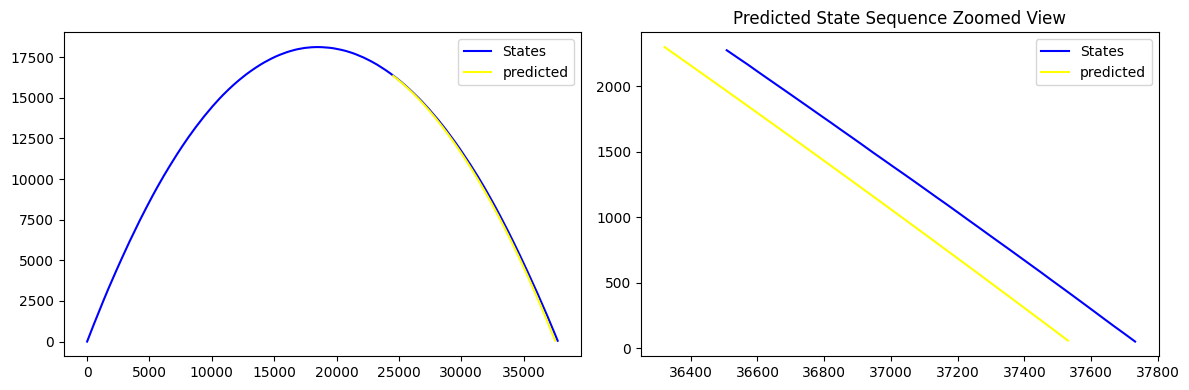

In [192]:
# Get next 450 predictions
predicted = filter.predict(out[:, -1], 450)

# Compute the estimate and extract the data
pred_xs = predicted[0, :]
pred_ys = predicted[1, :]

# Remove negative parts
index = np.argmax(pred_ys < 0)
pred_xs = pred_xs[:index]
pred_ys = pred_ys[:index]

# Plot it
plt.figure(figsize=(12, 4))
plt.title("Predicted State Sequence")
plt.subplot(121)
plt.plot(xs, ys, c="blue", label="States")
plt.plot(pred_xs, pred_ys, c="yellow", label="predicted")
plt.legend()
plt.subplot(122)
plt.title("Predicted State Sequence Zoomed View")
plt.plot(xs[-40:], ys[-40:], c="blue", label="States")
plt.plot(pred_xs[-40:], pred_ys[-40:], c="yellow", label="predicted")
plt.legend()
plt.tight_layout()
plt.show()

## Problem 9

Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250. 
Note that you may have to take a few extra time steps to predict the point of origin. 
Plot these predicted states (in green) together with the original state sequence. 
Zoom in to see how accurate your prediction is. 

Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$. 
Compare to the previous results. 
Which is better? 
Why?

X-coordinate of point of origin prediction for step 250: -122.2383082637104


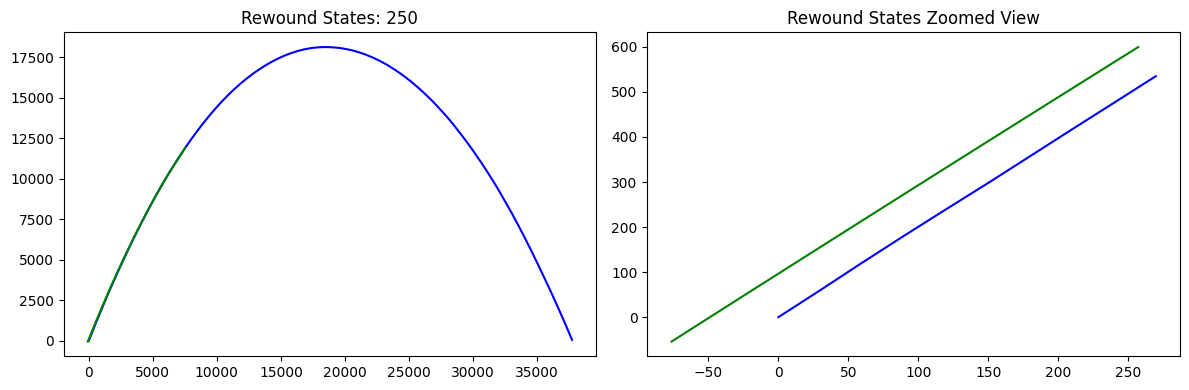

In [223]:
rew_predicted = filter.rewind(states[:, 250], 252)

# Compute the estimate and extract the data
rew_xs = rew_predicted[0, :]
rew_ys = rew_predicted[1, :]

# FInd first positive entry
index = next((i for i, x in enumerate(rew_ys) if x > 0), None)
guess = (rew_xs[index-1] + rew_xs[index])
print("X-coordinate of point of origin prediction for step 250:", guess)
# Plot it
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Rewound States: 250")
plt.plot(xs, ys, c="blue", label="States")
plt.plot(rew_xs, rew_ys, c="green", label="Rewound")
plt.subplot(122)
plt.title("Rewound States Zoomed View")
plt.plot(xs[:10], ys[:10], c="blue", label="States")
plt.plot(rew_xs[:12], rew_ys[:12], c="green", label="Rewound")
plt.tight_layout()
plt.show()

X-coordinate of point of origin prediction for step 600: -320.3779091282828


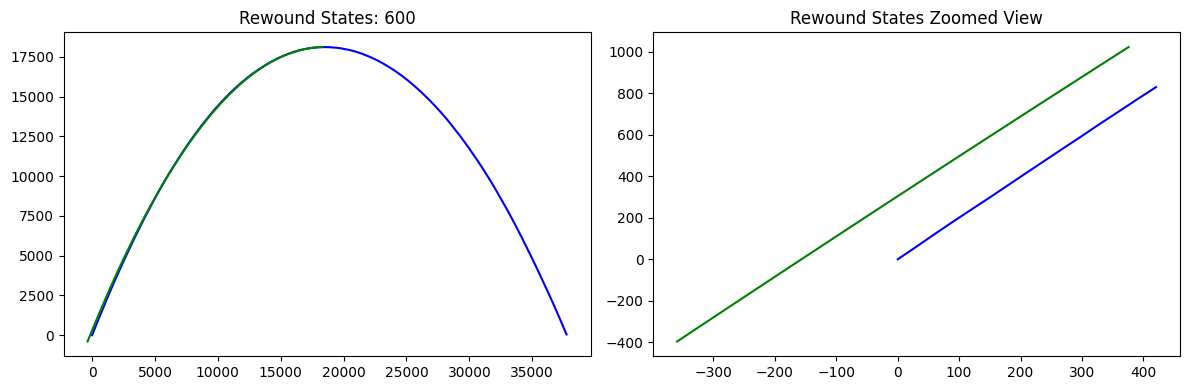

In [224]:
rew_predicted = filter.rewind(states[:, 600], 610)

# Compute the estimate and extract the data
rew_xs = rew_predicted[0, :]
rew_ys = rew_predicted[1, :]

# FInd first positive entry
index = next((i for i, x in enumerate(rew_ys) if x > 0), None)
guess = (rew_xs[index-1] + rew_xs[index])
print("X-coordinate of point of origin prediction for step 600:", guess)
# Plot it
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title("Rewound States: 600")
plt.plot(xs, ys, c="blue", label="States")
plt.plot(rew_xs, rew_ys, c="green", label="Rewound")
plt.subplot(122)
plt.title("Rewound States Zoomed View")
plt.plot(xs[:15], ys[:15], c="blue", label="States")
plt.plot(rew_xs[:25], rew_ys[:25], c="green", label="Rewound")
plt.tight_layout()
plt.show()

As expected, the state at 250 was more accurate. This makes sense because it was closer to the true starting point. So, the error compounded less over time.